# Breast Cancer Image Classification Hierarchical Models Approach

The dataset Contatins breast images for normal, benign, and malignant breast cancers along with segmentation masks, 
after discarding the segmentation masks from training we have 445 benign , 220 malignant, 133 normal ultrasound images

**we care to reduce false normal predictions, f1-score, confusion matrix will be our chosen metrics**

## Importing Modules

In [1]:
import numpy as np
import os
import optuna
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, make_scorer
import warnings
from sklearn import svm
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### We Binarize our problem to just predicting whether the image is normal or cancerous 

#### **We notice that unlike all usual datasets the normal is not the dominant class**

### General purpose preprocessing is done just resizing and normalization

In [2]:
def load(image_folder, label_value):
    images = [img for img in os.listdir(image_directory + image_folder)]
    for i, image_name in enumerate(images):
        if image_name.split('.')[1] == 'png':
            image = cv2.imread(image_directory + image_folder + image_name)
            if image is not None:
                image = Image.fromarray(image)
                image = image.resize((SIZE, SIZE))
                image = np.array(image)
                if "mask" in image_name:
                    continue
                
                dataset.append(image)
                label.append(label_value)
                if i == 133:
                    break

In [3]:
image_directory = "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/"
SIZE = 64
dataset = []
label = []
load('normal/', 0)
load('benign/', 1)  
load('malignant/', 2)
dataset = np.array(dataset)
label = np.array(label)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset.reshape(dataset.shape[0], -1), label, test_size=0.1, shuffle=True, random_state=42, stratify=label)

## Boosting a Logistic Regression Model with adaptive boosting 

#### **The feature vectors are flattened to a (1, 28x28) vector and the data was split into 80~20 format with stratified sampling to ensure that the training and testing distributions are the same , random shuffling is also enabled**

#### **we trained an adaptive boosting algorithm with a 100 logistic regression model as a weak learners that are regularized with the C hyperparam to 0.01 and a learning rate of 0.1 **

In [5]:
base_estimator = LogisticRegression(max_iter=5000, C=0.0001)  
n_estimators = 100  
learning_rate =0.1  
adaboost_model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

In [6]:
kf = KFold(n_splits=10,shuffle=True, random_state=42)
scorer = make_scorer(f1_score)
scores = cross_val_score(adaboost_model, X_train, (y_train > 0).astype(int), cv=kf, scoring=scorer)  
mean_f1_score = np.mean(scores)
print("Mean F1 Score:", mean_f1_score)

Mean F1 Score: 0.8366125945732861


In [7]:
adaboost_model.fit(X_train, (y_train > 0).astype(int))

AdaBoostClassifier(base_estimator=LogisticRegression(C=0.0001, max_iter=5000),
                   learning_rate=0.1, n_estimators=100, random_state=42)

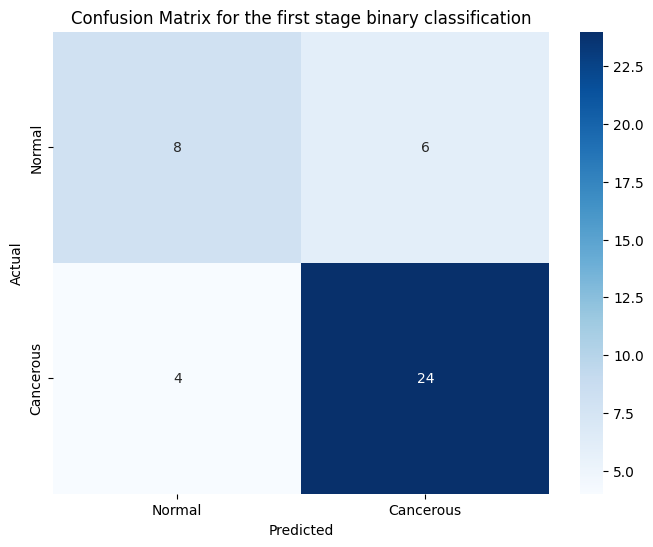

In [8]:
y_pred = adaboost_model.predict(X_test)
cm = confusion_matrix((y_test > 0).astype(int), y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Cancerous'],
            yticklabels=['Normal', 'Cancerous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the first stage binary classification')
plt.show()

In [9]:
tn, fp, fn, tp = cm.ravel()
# Calculating the false negative rate
fnr = fn / (fn + tp)
fnr_percentage = fnr * 100
print("False Negative Rate: {:.2f}%".format(fnr_percentage))

False Negative Rate: 14.29%


### The F1-Score is relativly acceptable compared to scores from other Classical ML approaches , In addition to very low false negative rate

In [10]:
accuracy_score((y_test > 0).astype(int), y_pred)

0.7619047619047619

### Now Classifying Benign versus Malignant

In [11]:
mask = ~(y_train==0)

### Boosting Logistic regression model for the second task

#### **Using the same setup for the first stage for adaboost and logistic regression also yeild acceptable F1-Score results**

In [12]:
log_reg = LogisticRegression(max_iter=5000, C=0.001)
adaboost_model_2 = AdaBoostClassifier(base_estimator=log_reg, n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
kf = KFold(n_splits=10,shuffle=True, random_state=42)
scorer = make_scorer(f1_score)
scores = cross_val_score(adaboost_model_2, X_train[mask], ((y_train[mask]-1)>0).astype(int), cv=kf, scoring=scorer)  
mean_f1_score = np.mean(scores)
print("Mean F1 Score:", mean_f1_score)
adaboost_model_2.fit(X_train[mask], y_train[mask])

Mean F1 Score: 0.8453601116258929


AdaBoostClassifier(base_estimator=LogisticRegression(C=0.001, max_iter=5000),
                   learning_rate=0.1, n_estimators=100, random_state=42)

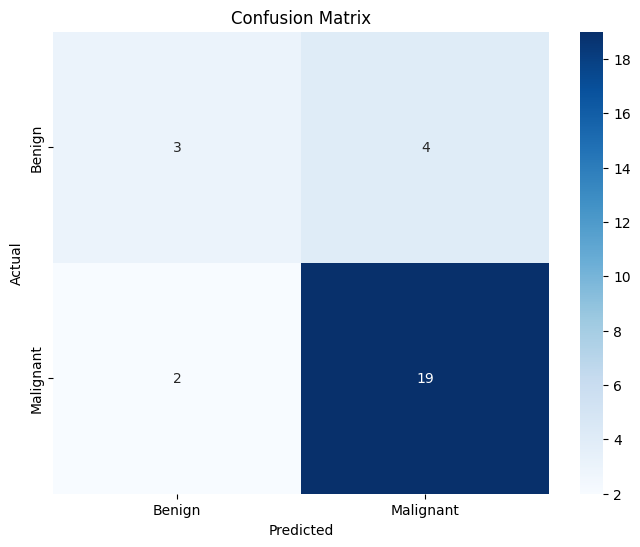

In [13]:
cm = confusion_matrix(y_test[~(y_test==0)], adaboost_model_2.predict(X_test[~(y_test==0)]))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()